In [26]:
import os
import requests
import pprint
from bs4 import BeautifulSoup
import pandas as pd
import csv
import time
import random
import seaborn as sns
import matplotlib.pyplot as plt
import logging
sns.set()

# Introduction 
In this notebook we will go through the process of collecting and analyzing our desired data, namely contact data for all general education schools in Germany.
These happen to be available through a HTML source code of a webpage, which contains ~33000 URLs each referring to a unique school. We are mostly interested in the Bundesland (County) and email of these schools. With this information we can determine how many schools per county we can effectively reach by mail for our survey. We will also be able to decide if we have to buy additional data sets to increase our coverage and, if yes, which ones.

**So we try to answer the following two questions:**
* For how many schools (per county) can we get email addresses? 
* Should we buy 3rd party data to increase our coverage?

**To do this we will:**
* Extract URLs from the given HTML fle
* Scrape these URLs for our desired data
* Preprocess the data
* Explore and analyze the data for email coverage per county


# Dummy Data
This section uses dummy data to illustrate the process of data collection **without actually visting scraping any real websites!**  
So feel free to run through this section!

## Data Collection

### Extract URLs from a HTML file

In [42]:
# write a function to extract urls from html_file and save them to save_file_name
# option to provide a base url to filter (e.g. only return urls that start with 'http://www.schulliste.com/')

def extract_html_to_url(html_file, save_file_name, base_url=''):
    """
    Extracts URLs and corresponding school names from an HTML file and saves them to a CSV file.

    Args:
        html_file (str): Path to the input HTML file.
        save_file_name (str): Path to the output CSV file.
        base_url (str, optional): Filter to include only URLs starting with this base. Defaults to '' (include all).

    Returns:
        None: The function writes the extracted data to a CSV file.
    """
    
    # Step 1: Load the HTML file
    with open(html_file, 'r', encoding='utf-8') as file:
        html_content = file.read()
    
    # Step 2: Parse the HTML using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Step 3: Find all 'a' tags with an 'href' attribute
    links = soup.find_all('a', href=True)
    
    # Step 4: Extract school names and URLs
    # Filter for URLs starting with the given base_url (if provided)
    data = []
    for link in links:
        school_name = link.get_text(strip=True) # Get the school name
        url = link['href'] # Get the URL
        if school_name and url.startswith(base_url): # avoid empty entries and check that URL starts with base URL 
            data.append([school_name, url])
    
    # Save data to a CSV file
    with open(save_file_name, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.writer(file)
        # Write the header row
        writer.writerow(['Name', 'URL'])
        # Write the data rows
        writer.writerows(data)



In [43]:
extract_html_to_url('data/webpage_dummy.txt', 'data/dummy_urls.csv', base_url='')

#### The resulting CSV-File containing URLs

In [44]:
df_dummy = pd.read_csv('data/dummy_urls.csv')
df_dummy

,Name,URL
0,School 1,http://www.example.com/school1
1,School 2,http://www.example.com/school2
2,School 3,http://www.example.com/school3
3,School 4,http://www.example.com/school4
4,School 5,http://www.example.com/school5
5,School 6,http://www.example.com/school6
6,School 7,http://www.example.com/school7
7,School 8,http://www.example.com/school8
8,School 9,http://www.example.com/school9
9,School 10,http://www.example.com/school10


### Write functions to scrape a single URL

**This looks good! Now let's write a function, that visits each URL and extracts our desired information. Let's scrape the following data:**

['Name','Bundesland', 'Schultyp', 'Kategorien', 'Anschrift', 'Telefon', 'Fax', 'E-Mail', 'Homepage']  
(Note: We already have the 'Name' column in df_dummy)

Note:
This scraper was designed for a website/html-source where:
- Keys were stored in `<div>` elements with the class `c1`.
- Corresponding values were stored in `<div>` elements with the class `c2`.

If you use this code with a different website, you may need to update the `find_all` logic to match the new structure.

We will handle possible errors by inserting '--' for any missing value.

In [64]:
# Function to fetch profile information from a given URL
# Use is_dummy=False for a list of real URLs

def get_profile_info(file_path, is_dummy=True):
    """
    Fetches profile information from a given URL or HTML file.

    Args:
        file_path (str): Path to the local HTML file or URL.
        is_dummy (bool): True if working with a local HTML file, False for real URLs.

    Returns:
        BeautifulSoup element: Parsed profile information.
    """
    if not is_dummy:
        # Fetch page content from URL
        url = file_path
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        profile_info = soup.find_all('div','profil_basic_info')
        return profile_info
    else:
        # Load and parse the local HTML file
        with open(file_path, 'r', encoding='utf-8') as file:
            html_content = file.read()
        soup = BeautifulSoup(html_content, 'html.parser')
        profile_info = soup.find_all('div', 'profil_basic_info')
        return profile_info


def get_keys(profile_info, is_dummy=True):
    """
    Extracts keys (field names) from the profile information.

    Args:
        profile_info (BeautifulSoup element): Parsed profile information.
        is_dummy (bool): True if working with a local HTML file, False for real URLs.

    Returns:
        list: A list of keys (field names).
    """
    if not is_dummy:
        data = profile_info[0].find_all('div', class_='c1')
    else:
        data = profile_info.find_all('div', class_='c1')
    keys = []
    for d in data:
        key = d.text.replace(':','')
        keys.append(key)
    return keys


# Example of all keys 
# keys_gen = ['Bundesland', 'Schultyp', 'Kategorien', 'Anschrift', 'Telefon', 'Fax', 'E-Mail', 'WWW']

# Function to extract a single record from the profile information
# Handle errors by inserting '--' if a value is missing
def get_single_record(profile_info, keys, value_class='c2'):
    """
    Extracts a single record from the profile information.

    Args:
        profile_info (BeautifulSoup element): Parsed profile information.
        keys (list): List of field names.
        value_class (str): Class name for HTML elements containing values.

    Returns:
        dict: A dictionary containing the extracted data.
    """
    data_values = profile_info.find_all('div', class_='c2')
    record = {}  

    # Map keys to their corresponding values
    for idx, key in enumerate(keys):
        try:
            # Extract 'Bundesland'
            if 'Bundesland' in key:
                record['Bundesland'] = data_values[idx].find('a').text or '--'
            # Extract 'Schultyp'
            elif 'Schultyp' in key:
                record['Schultyp'] = data_values[idx].find('a').text or '--'
            # Extract 'Kategorien'
            elif 'Kategorien' in key:
                categories = [cat.text for cat in data_values[idx].find_all('a')]
                record['Kategorien'] = ' '.join(categories) if categories else '--'
            # Extract 'Anschrift'
            elif 'Adresse' in key:
                record['Adresse'] = data_values[idx].text.replace(u'\xa0', u' ') or '--'
            # Extract 'Telefon'
            elif 'Telefon' in key:
                record['Telefon'] = data_values[idx].text or '--'
            # Extract 'Fax'
            elif 'Fax' in key:
                record['Fax'] = data_values[idx].text or '--'
            # Extract 'E-Mail'
            elif 'E-Mail' in key:
                emails = data_values[idx].find_all('a')
                record['E-Mail'] = f"{emails[0].text}@{emails[1].text}" if len(emails) > 1 else '--'
            # Extract 'Homepage'
            elif 'WWW' in key:
                record['WWW'] = data_values[idx].find('a').text or '--'
        except (IndexError, AttributeError):
            record[key] = '--'  # Fallback for missing data

    return record


#### Example output for a single URL

In [57]:
file_path = 'data/dummy_profile.html'
profile = get_profile_info(file_path)
keys    = get_keys(profile[0])
record  = get_single_record(profile[0], keys=keys)
record

{'Bundesland': 'Baden-Württemberg',
 'Schultyp': 'Grundschule',
 'Kategorien': 'Bildung Öffentlich',
 'Telefon': '0711 123456',
 'Fax': '0711 654321',
 'email': 'info@schule.de',
 'Homepage': 'http://www.schule.de'}

### Loop over all URLs

**Let's write a loop to scrape all the data from another dummy HTML containing data of 10 schools:**
**Within the loop we will:**
* keep track of the compute time
* keep track of possible request errors
* limit our request rate to avoid overloading the server
* do intermediate saves and progress reporting

After that we will save the final data to a csv file.


In [47]:
# urls = get_profile_info('data/dummy_10_profiles.html')

# start_time = time.time() # track time 
# records_all = []
# url_fails = 0 # track url errors
# n = len(urls)  # Dynamically adjust n
# count = 0

# for i in range(n):
#     count += 1
#     try:
#         profile_1 = urls[i]
#         keys_1 = get_keys(profile_1)
#         record_single = get_single_record(profile_1, keys_1)
#         records_all.append(record_single)
#     except requests.exceptions.RequestException as e:
#         # Handle URL-related errors
#         record_single = {
#             'Bundesland': '--', 'Schultyp': '--', 'Kategorien': '--', 
#             'Adresse': '--', 'Telefon': '--', 'Fax': '--', 
#             'email': '--', 'Homepage': '--'
#         }
#         records_all.append(record_single)
#         url_fails += 1
#         print(f'Error at {count} (URL: {urls[i]}): {e}')
    
#     # Add a randomized delay to avoid overloading the server and mimic human behaviour to not get flagged
#     time.sleep(random.uniform(0.2, 0.5))

#     # Periodic progress reporting and intermediate save
#     if count % 1000 == 0:
#         print(f'{count} finished with {fails} errors so far.')
#         df_partial = pd.DataFrame.from_dict(records_all)
#         df_partial.insert(0, 'Name', df_dummy['Name'][:len(records_all)])
#         df_partial.to_csv(f'Schuldaten_partial_{count}.csv', index=False)
#         print(f'Intermediate save at {count} entries.')

# # Final save
# df_all = pd.DataFrame.from_dict(records_all)
# df_all.insert(0, 'Name', df_dummy['Name'][:n])
# df_all.to_csv('data/school_data_dummy.csv', index=False)
# print(f"The process took {round(time.time() - start_time,2)} seconds. For {url_fails} schools, the URL couldn't be accessed.")

In [65]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.StreamHandler()]
)

def save_partial_data(records, df, count, output_path):
    """
    Saves a partial dataset to a CSV file.

    Args:
        records (list): List of scraped records.
        df (DataFrame): DataFrame containing the original data.
        count (int): Current count of processed records.
        output_path (str): File path to save the partial dataset.
    """
    df_partial = pd.DataFrame.from_dict(records)
    df_partial.insert(0, 'Name', df['Name'][:len(records)])
    df_partial.to_csv(output_path, index=False)
    logging.info(f"Intermediate save: {count} records saved to {output_path}.")

def scrape_profiles(urls, df, output_path, delay_range=(0.2, 0.5)):
    """
    Scrapes profile data from a list of URLs and saves the data to a CSV file.

    Args:
        urls (list): List of URLs to scrape.
        df (DataFrame): DataFrame containing school names.
        output_path (str): File path to save the final dataset.
        delay_range (tuple): Min and max delay (in seconds) between requests.
    """
    start_time = time.time()
    records_all = []
    url_fails = 0

    if not urls or len(urls) == 0:
        logging.error("No URLs provided. Exiting.")
        return

    for count, url in enumerate(urls, start=1):
        try:
            profile_info = url
            keys = get_keys(profile_info)
            record = get_single_record(profile_info, keys)
            records_all.append(record)
            print(record)
        except Exception as e:
            logging.error(f"Error processing URL {count}: {url}. Error: {e}")
            # Append placeholder record for failed URLs
            record = {
                'Bundesland': '--', 'Schultyp': '--', 'Kategorien': '--',
                'Adresse': '--', 'Telefon': '--', 'Fax': '--',
                'email': '--', 'Homepage': '--'
            }
            records_all.append(record)
            url_fails += 1

        # Add a randomized delay to avoid being flagged as a bot
        time.sleep(random.uniform(*delay_range))

        # Save intermediate progress every 1000 records
        if count % 1000 == 0:
            save_partial_data(
                records=records_all,
                df_dummy=df_dummy,
                count=count,
                output_path=f"Schuldaten_partial_{count}.csv"
            )

    # Save final dataset
    df_all = pd.DataFrame.from_dict(records_all)
    df_all.insert(0, 'Name', df['Name'][:len(records_all)])
    df_all.to_csv(output_path, index=False)

    total_time = round(time.time() - start_time, 2)
    logging.info(f"Scraping completed in {total_time} seconds.")
    logging.info(f"Total URLs processed: {len(urls)}. Failed: {url_fails}.")


In [66]:
urls = get_profile_info('data/dummy_10_profiles.html')
df_dummy = pd.read_csv('data/dummy_urls.csv')
scrape_profiles(urls=urls, df=df_dummy, output_path="data/school_data_dummy.csv")

{'Bundesland': 'State 1', 'Schultyp': 'Type 1', 'Kategorien': 'Category A 1 Category B 1', 'Adresse': 'Street 1 123, City 1', 'Telefon': '123-456-781', 'Fax': '123-456-871', 'E-Mail': 'email1@example.com', 'WWW': 'http://www.school1.com'}
{'Bundesland': 'State 2', 'Schultyp': 'Type 2', 'Kategorien': 'Category A 2 Category B 2', 'Adresse': 'Street 2 123, City 2', 'Telefon': '123-456-782', 'Fax': '123-456-872', 'E-Mail': 'email2@example.com', 'WWW': 'http://www.school2.com'}
{'Bundesland': 'State 3', 'Schultyp': 'Type 3', 'Kategorien': 'Category A 3 Category B 3', 'Adresse': 'Street 3 123, City 3', 'Telefon': '123-456-783', 'Fax': '123-456-873', 'E-Mail': 'email3@example.com', 'WWW': 'http://www.school3.com'}
{'Bundesland': 'State 4', 'Schultyp': 'Type 4', 'Kategorien': 'Category A 4 Category B 4', 'Adresse': 'Street 4 123, City 4', 'Telefon': '123-456-784', 'Fax': '123-456-874', 'E-Mail': 'email4@example.com', 'WWW': 'http://www.school4.com'}
{'Bundesland': 'State 5', 'Schultyp': 'Type 

2024-11-22 22:31:54,725 - INFO - Scraping completed in 3.26 seconds.
2024-11-22 22:31:54,726 - INFO - Total URLs processed: 10. Failed: 0.


#### The resulting CSV-File containing school data

In [67]:
df_dummy = pd.read_csv('data/school_data_dummy.csv')
df_dummy

,Name,Bundesland,Schultyp,Kategorien,Adresse,Telefon,Fax,E-Mail,WWW
0,School 1,State 1,Type 1,Category A 1 Category B 1,"Street 1 123, City 1",123-456-781,123-456-871,email1@example.com,http://www.school1.com
1,School 2,State 2,Type 2,Category A 2 Category B 2,"Street 2 123, City 2",123-456-782,123-456-872,email2@example.com,http://www.school2.com
2,School 3,State 3,Type 3,Category A 3 Category B 3,"Street 3 123, City 3",123-456-783,123-456-873,email3@example.com,http://www.school3.com
3,School 4,State 4,Type 4,Category A 4 Category B 4,"Street 4 123, City 4",123-456-784,123-456-874,email4@example.com,http://www.school4.com
4,School 5,State 5,Type 5,Category A 5 Category B 5,"Street 5 123, City 5",123-456-785,123-456-875,email5@example.com,http://www.school5.com
5,School 6,State 6,Type 6,Category A 6 Category B 6,"Street 6 123, City 6",123-456-786,123-456-876,email6@example.com,http://www.school6.com
6,School 7,State 7,Type 7,Category A 7 Category B 7,"Street 7 123, City 7",123-456-787,123-456-877,email7@example.com,http://www.school7.com
7,School 8,State 8,Type 8,Category A 8 Category B 8,"Street 8 123, City 8",123-456-788,123-456-878,email8@example.com,http://www.school8.com
8,School 9,State 9,Type 9,Category A 9 Category B 9,"Street 9 123, City 9",123-456-789,NaN,NaN,http://www.school9.com
9,School 10,State 10,--,--,--,--,--,--,--


## Data Preprocessing

**Although we tried to insert '--' when we have no value we still have some NaN in there.
As for now we are mostly interested in the county ('Bundesland') and email address, especially whether an email address is available at all. For this we will add a column 'email_encoded' which is 1 if a valid email entry exists and 0 if not. We will also keep the category and type.**

In [70]:
# preprocessing our dummy data
df_dummy_mail_encoded = pd.read_csv('data/school_data_dummy.csv')
# encode email: 1 if email exists, 0 if not
df_dummy_mail_encoded['email_encoded'] = df_dummy_mail_encoded['E-Mail'].apply(lambda x: 1 if isinstance(x,str) and '@' in x else 0)
df_dummy_preprocessed = df_dummy_mail_encoded.drop(columns=['Name','Adresse', 'Telefon', 'WWW', 'Fax', 'E-Mail'])
df_dummy_preprocessed

,Bundesland,Schultyp,Kategorien,email_encoded
0,State 1,Type 1,Category A 1 Category B 1,1
1,State 2,Type 2,Category A 2 Category B 2,1
2,State 3,Type 3,Category A 3 Category B 3,1
3,State 4,Type 4,Category A 4 Category B 4,1
4,State 5,Type 5,Category A 5 Category B 5,1
5,State 6,Type 6,Category A 6 Category B 6,1
6,State 7,Type 7,Category A 7 Category B 7,1
7,State 8,Type 8,Category A 8 Category B 8,1
8,State 9,Type 9,Category A 9 Category B 9,0
9,State 10,--,--,0


# Transition to Real Data

After illustrating the data collection process using dummy data, we now move to analyzing real-world data. Initially, the data was extracted from the website `http://www.schulliste.eu/` in 2021. However, due to changes in the website's HTML structure, our scraping functions (`get_keys()`, `get_single_record()`) are no longer compatible with the updated site.

We will extract the RULs from the webpage.txt which returns a list of all school names and URLs.
After that, as we cannot access these URLs with our scraper anymore, we will continue with an archived dataset from 2021 which contains email information encoded for all schools at that time.

This dataset provides a solid foundation for our analysis.



## Data Collection

In [71]:
# Extract URLs from webpage.txt
extract_html_to_url('data/webpage.txt', 'data/real_urls.csv', base_url='http://www.schulliste.eu/schule')

# Load the extracted URLs and inspect a sample
df_real = pd.read_csv('data/real_urls.csv')
df_real.head(10)

,Name,URL
0,Ameisenbergschule Grund- und Hauptschule,http://www.schulliste.eu/schule/1-ameisenbergs...
1,Falkert-Schule Grund- und Hauptschule mit Werk...,http://www.schulliste.eu/schule/2-falkert-schu...
2,Vogelsangschule Grundschule,http://www.schulliste.eu/schule/3-vogelsangsch...
3,Grund- und Werkrealschule Gablenberg,http://www.schulliste.eu/schule/4-grund-und-we...
4,Grundschule Gaisburg,http://www.schulliste.eu/schule/5-grundschule-...
5,Heusteigschule Grund- und Werkrealschule,http://www.schulliste.eu/schule/6-heusteigschu...
6,Grundschule im Sonnigen Winkel,http://www.schulliste.eu/schule/7-grundschule-...
7,Grundschule im Sonnigen Winkel AuÃenstelle Le...,http://www.schulliste.eu/schule/8-grundschule-...
8,Jakobschule Grundschule,http://www.schulliste.eu/schule/9-jakobschule-...
9,Lerchenrainschule Grundschule,http://www.schulliste.eu/schule/10-lerchenrain...


### Continue with archived Table from 2021

In [76]:
# Load the archived dataset
df_raw = pd.read_csv('data/school_data_anon.csv')

# Drop unnecessary columns for this analysis
df = df_raw.drop(columns=['Unnamed: 0', 'Schultyp', 'Kategorien'])

# Sample from the archived dataset
df.head()

,Bundesland,email_encoded
0,Baden-Württemberg,1
1,Baden-Württemberg,1
2,Baden-Württemberg,0
3,Baden-Württemberg,1
4,Baden-Württemberg,1


## Explore and analyze the data

### Initial Exploration & Grouped Analysis
We begin by examining the distribution of schools and email coverage across the Bundesländer. 


In [77]:
df.describe(include='all')

,Bundesland,email_encoded
count,33789,33789.000000
unique,17,NaN
top,Nordrhein-Westfalen,NaN
freq,7021,NaN
mean,NaN,0.345734
std,NaN,0.475614
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


Let's inspect the Bundesländer (counties)

In [74]:
df['Bundesland'].unique()

array(['Baden-Württemberg', '--', 'Hessen', 'Niedersachsen',
       'Mecklenburg-Vorpommern', 'Nordrhein-Westfalen', 'Saarland',
       'Hamburg', 'Rheinland-Pfalz', 'Sachsen-Anhalt',
       'Schleswig-Holstein', 'Sachsen', 'Thüringen', 'Brandenburg',
       'Bayern', 'Bremen', 'Berlin'], dtype=object)

In [75]:
# Specify order to make sure '--' is at the front
order = ['--','Baden-Württemberg', 'Hessen', 'Niedersachsen',
       'Mecklenburg-Vorpommern', 'Nordrhein-Westfalen', 'Saarland',
       'Hamburg', 'Rheinland-Pfalz', 'Sachsen-Anhalt',
       'Schleswig-Holstein', 'Sachsen', 'Thüringen', 'Brandenburg',
       'Bayern', 'Bremen', 'Berlin']

# Count all rows per Bundesland
total_counts = df['Bundesland'].value_counts()
total_counts = total_counts.reindex(order)
total_counts

Bundesland
--                         138
Baden-Württemberg         2797
Hessen                    1922
Niedersachsen             5848
Mecklenburg-Vorpommern     608
Nordrhein-Westfalen       7021
Saarland                   599
Hamburg                    515
Rheinland-Pfalz           1519
Sachsen-Anhalt            1046
Schleswig-Holstein        1015
Sachsen                   1818
Thüringen                 1679
Brandenburg                939
Bayern                    6087
Bremen                     237
Berlin                       1
Name: count, dtype: int64

In [78]:
# Inspect how many of those have available email information (1) and how many don't (0)
email_data = df.groupby(['Bundesland', 'email_encoded']).size().unstack(fill_value=0)

# Ensure order
email_data = email_data.loc[order]

# Add column showing the coverage in % 
email_data['coverage (%)'] = round(email_data[1]/(email_data[1]+email_data[0]) * 100, 2)

# Calculate total count and coverage, save in new df
total_0 = email_data[0].sum()
total_1 = email_data[1].sum()
total_coverage = round(total_1 / (total_1+total_0) * 100, 2)
email_total_count = pd.DataFrame(data=[[total_0, total_1, total_coverage]],columns=email_data.columns)
email_total_count = [total_0, total_1, total_coverage]

# Ensure email_encoded shows whole integers
email_data[0] = email_data[0].astype(int)
email_data[1] = email_data[1].astype(int)

print(email_data)
print('\nTotal count and coverage:', email_total_count, '\n')

email_encoded              0     1  coverage (%)
Bundesland                                      
--                       138     0          0.00
Baden-Württemberg       2531   266          9.51
Hessen                    52  1870         97.29
Niedersachsen           3939  1909         32.64
Mecklenburg-Vorpommern     2   606         99.67
Nordrhein-Westfalen     6994    27          0.38
Saarland                 116   483         80.63
Hamburg                   25   490         95.15
Rheinland-Pfalz            0  1519        100.00
Sachsen-Anhalt           938   108         10.33
Schleswig-Holstein         1  1014         99.90
Sachsen                    8  1810         99.56
Thüringen               1316   363         21.62
Brandenburg                0   939        100.00
Bayern                  6047    40          0.66
Bremen                     0   237        100.00
Berlin                     0     1        100.00

Total count and coverage: [22107, 11682, 34.57] 



We have 138 schools without a Bundesland. 
For Berlin apparently we only have 1 school.
It's possible that at least some of the 138 schools could belong to Berlin, but we can't say for sure.
Therefore, we will ignore them for now.

Let's create some plots!

## Visualization

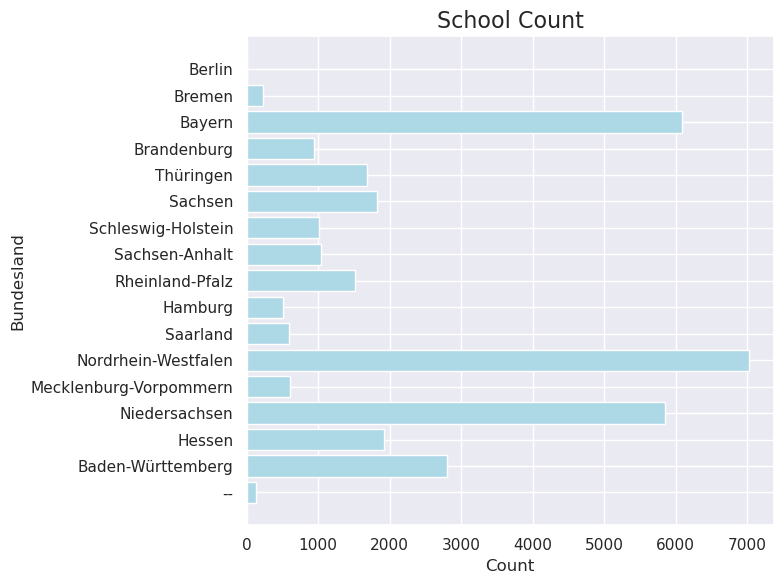

In [79]:
# Plot the counts per Bundesland in a horizontal bar chart
fig, ax = plt.subplots(figsize=(8, 6))

ax.barh(total_counts.index, total_counts.values, color='lightblue')

ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Bundesland", fontsize=12)
ax.set_title("School Count", fontsize=16)

plt.tight_layout()
plt.show()

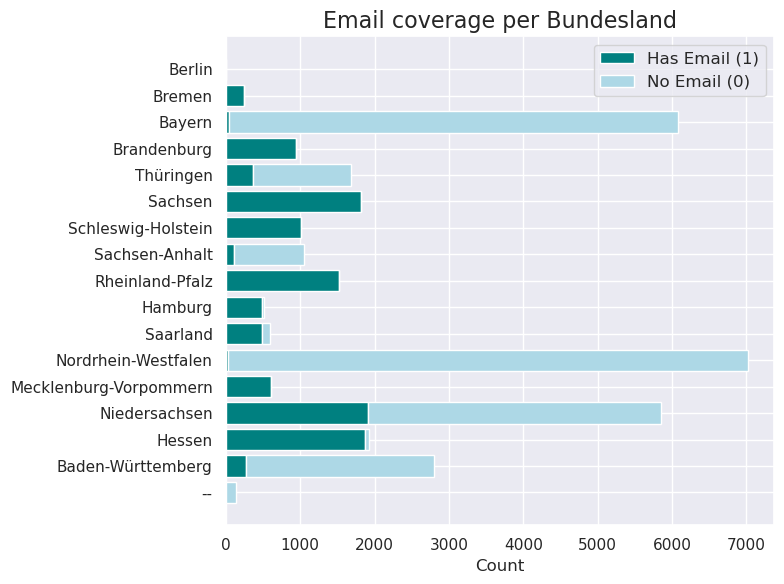

In [85]:
# Plot the email coverage per Bundesland
fig, ax = plt.subplots(figsize=(8, 6))

# Create the horizontal stacked bars
bundesland = email_data.index

# First stack: email_encoded = 1
ax.barh(bundesland, email_data[1], color='teal', label='Has Email (1)')

# Second stack: email_encoded = 0, stacked on top of email_encoded = 1
ax.barh(bundesland, email_data[0], left=email_data[1], color='lightblue', label='No Email (0)')

ax.set_xlabel("Count", fontsize=12)
# ax.set_ylabel("Bundesland", fontsize=12)
ax.set_title("Email coverage per Bundesland", fontsize=16)
ax.legend(prop={'size': 12})

plt.tight_layout()
plt.savefig("plots/school_email_coverage.png", dpi=300, bbox_inches='tight')  # Save the figure
plt.show()

Note that the coverage for Berlin is misleading as it's based on one entry only, although there's more than 1 school in Berlin.
It's important to note that this data set makes no claim to completeness.

Now we are going to visualize the 'Total Email Coverage' in a pie chart.
For this we will inspect 3 versions to visualize how our coverage changes if we would buy 3rd party data for 3 / 6 Bundesländer with the most missing emails:
1.    No Emails (0) vs Emails (1)
2.    No Emails (0) vs Emails (1) where Emails (1) includes the **3** Bundesländer with the most missing emails
3.    No Emails (0) vs Emails (1) where Emails (1) includes the **6** Bundesländer with the most missing emails

In [81]:
email_data

email_encoded,0,1,coverage (%)
Bundesland,,,
--,138,0,0.00
Baden-Württemberg,2531,266,9.51
Hessen,52,1870,97.29
Niedersachsen,3939,1909,32.64
Mecklenburg-Vorpommern,2,606,99.67
Nordrhein-Westfalen,6994,27,0.38
Saarland,116,483,80.63
Hamburg,25,490,95.15
Rheinland-Pfalz,0,1519,100.00


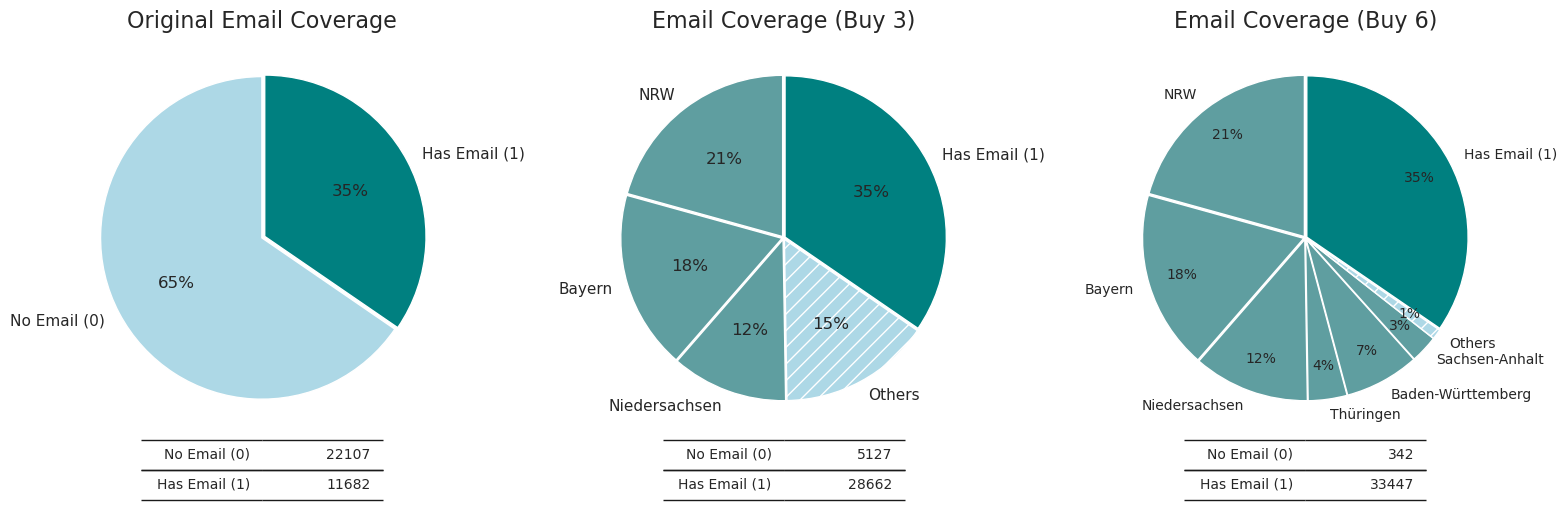

In [91]:
# Only use email_encoded columns
email_data = email_data[[0,1]]

# Get total email count, exclude coverage
email_counts = email_total_count[:2]

# Get count of the 6 Bundesländer with the most missing emails 
count_0_nrw = email_data.loc['Nordrhein-Westfalen', 0]
count_0_br  = email_data.loc['Bayern', 0]
count_0_ns  = email_data.loc['Niedersachsen', 0]
count_0_th  = email_data.loc['Thüringen', 0]
count_0_bw  = email_data.loc['Baden-Württemberg', 0]
count_0_sa  = email_data.loc['Sachsen-Anhalt', 0]

# Get the count of the remaining missing emails when 3 / 6 Bundesländer are included in 'email (1)'
# use iloc[:-1] to exclude to 'Total' row
count_0_others_3  = email_data[0].iloc[:-1].sum() - (count_0_nrw + count_0_br + count_0_ns)
count_0_others_6  = email_data[0].iloc[:-1].sum() - (count_0_nrw + count_0_br + count_0_ns + count_0_bw + count_0_th + count_0_sa)

# Create lists for corresponding plots
email_counts_detailed_3 = [count_0_nrw, count_0_br, count_0_ns, count_0_others_3, email_counts[1]]
email_counts_detailed_6 = [count_0_nrw, count_0_br, count_0_ns, count_0_th, count_0_bw, count_0_sa, count_0_others_6, email_counts[1]]

# Data for small tables below plots showing absolute counts
plot1_counts = [email_counts[0], email_counts[1]]
plot2_counts = [email_counts[0] - (count_0_nrw + count_0_br + count_0_ns), 
                email_counts[1] + count_0_nrw + count_0_br + count_0_ns]
plot3_counts = [count_0_others_6, email_counts[0] + email_counts[1] - count_0_others_6]

# Labels for the pie charts
labels_detailed_3 = [
    'NRW',
    'Bayern',
    'Niedersachsen',
    'Others',
    'Has Email (1)'
]

labels_detailed_6 = [
    'NRW',
    'Bayern',
    'Niedersachsen',
    'Thüringen',
    'Baden-Württemberg',
    'Sachsen-Anhalt',
    'Others',
    'Has Email (1)'
]


# Write a function to adjust the coloring of the pie charts if needed. Optionally, specify a save_path 
def plot_pie_charts(colors1, colors2, colors3, save_path=None):

    # 3 Pie charts next to each other
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))  
    
    # Plot the first pie chart
    axes[0].pie(
        email_counts,
        labels=['No Email (0)', 'Has Email (1)'],
        autopct='%1.0f%%',
        colors=colors1,
        startangle=90,
        explode=(0, 0.02)
    )
    axes[0].set_title('Original Email Coverage', fontsize=16)

    # Add table below
    plot1_table_data = [["No Email (0)", plot1_counts[0]],
                        ["Has Email (1)", plot1_counts[1]]]
    axes[0].table(cellText=plot1_table_data, loc='bottom', edges = 'horizontal', bbox=[0.2, -0.15, 0.6, 0.15])
    
    # Plot the second pie chart 
    # Add hatches to highlight 'Others' part
    hatches_3 = ['//' if label == 'Others' else None for label in labels_detailed_3]
    
    wedges_3, texts, autotexts = axes[1].pie(
        email_counts_detailed_3,
        labels=labels_detailed_3,
        autopct='%1.0f%%',
        colors=colors2,
        startangle=90,
        explode=(0.01, 0.01, 0.01, 0.01, 0.01)
    )
    
    for i, wedge in enumerate(wedges_3):
        if hatches_3[i]:  
            wedge.set_hatch(hatches_3[i])
    
    axes[1].set_title('Email Coverage (Buy 3)', fontsize=16)

    # Add table below
    plot2_table_data = [["No Email (0)", plot2_counts[0]],
                        ["Has Email (1)", plot2_counts[1]]]
    axes[1].table(cellText=plot2_table_data, loc='bottom', edges = 'horizontal', bbox=[0.2, -0.15, 0.6, 0.15])
    
    # Plot the third pie chart
    # Add hatches to highlight 'Others' part
    hatches_6 = ['//' if label == 'Others' else None for label in labels_detailed_6]
    
    wedges_6, texts, autotexts = axes[2].pie(
        email_counts_detailed_6,
        labels=labels_detailed_6,
        autopct='%1.0f%%',
        colors=colors3,
        startangle=90,
        explode=(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01)
        , pctdistance=0.79
        , textprops={'fontsize':10}
    )
    
    for i, wedge in enumerate(wedges_6):
        if hatches_6[i]:  
            wedge.set_hatch(hatches_6[i])
    
    axes[2].set_title('Email Coverage (Buy 6)', fontsize=16)

    plot3_table_data = [["No Email (0)", plot3_counts[0]],
                    ["Has Email (1)", plot3_counts[1]]]
    axes[2].table(cellText=plot3_table_data, loc='bottom', edges = 'horizontal', bbox=[0.2, -0.15, 0.6, 0.15])
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


# Colors for the pie charts
colors1 = ['lightblue', 'teal']
colors2 = ['cadetblue', 'cadetblue', 'cadetblue', 'lightblue', 'teal']
colors3 = ['cadetblue', 'cadetblue', 'cadetblue', 'cadetblue', 'cadetblue', 'cadetblue', 'lightblue', 'teal']
plot_pie_charts(colors1, colors2, colors3, save_path="plots/email_coverage_comparison_with_tables.png")

### Extra: Visualize coverage on map plot of Germany
In this extra section the coverages are plotted on top of the map of Germany with its Bundesländer.

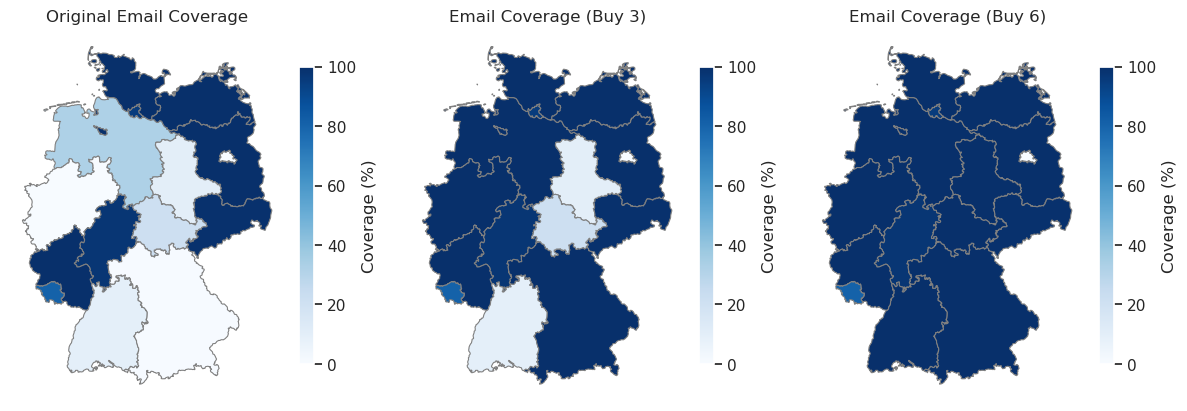

In [90]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
file_path = "data/vg2500_geo84/vg2500_bld.shp"
gdf_base = gpd.read_file(file_path)

# Base `email_data` setup
email_data = df.groupby(['Bundesland', 'email_encoded']).size().unstack(fill_value=0)
email_data = email_data.loc[order]
email_data['coverage (%)'] = round(email_data[1] / (email_data[1] + email_data[0]) * 100, 2)

# Function to modify `coverage (%)`
def modify_coverage(data, changes):
    modified_data = data.copy()
    for bundesland, new_value in changes.items():
        modified_data.loc[bundesland, 'coverage (%)'] = new_value
    return modified_data

# Modifications for the second and third plots
modifications_1 = {
    'Berlin': 0,
}
modifications_2 = {
    'Berlin': 0,
    'Nordrhein-Westfalen': 100,
    'Bayern': 100,
    'Niedersachsen': 100
}
modifications_3 = {
    'Berlin': 0,
    'Nordrhein-Westfalen': 100,
    'Bayern': 100,
    'Niedersachsen': 100,
    'Thüringen': 100,
    'Baden-Württemberg': 100,
    'Sachsen-Anhalt': 100
}

# Apply modifications
email_data_1 = modify_coverage(email_data, modifications_1)
email_data_2 = modify_coverage(email_data, modifications_2)
email_data_3 = modify_coverage(email_data, modifications_3)

# Merge data with GeoDataFrame
gdf_1 = gdf_base.merge(email_data_1, how='left', left_on='GEN', right_on='Bundesland')
gdf_2 = gdf_base.merge(email_data_2, how='left', left_on='GEN', right_on='Bundesland')
gdf_3 = gdf_base.merge(email_data_3, how='left', left_on='GEN', right_on='Bundesland')

# Plot the maps
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Plot 1: Original
gdf_1.plot(
    column='coverage (%)', 
    cmap='Blues', 
    linewidth=0.8, 
    edgecolor='gray', 
    legend=True, 
    ax=axes[0],
    legend_kwds={
        'shrink': 0.8,
        'aspect': 20,
        'label': "Coverage (%)",
        'orientation': 'vertical'
    }
)
axes[0].set_title("Original Email Coverage", fontsize=12)
axes[0].axis('off')

# Plot 2: Modified coverage
gdf_2.plot(
    column='coverage (%)', 
    cmap='Blues', 
    linewidth=0.8, 
    edgecolor='gray', 
    legend=True, 
    ax=axes[1],
    legend_kwds={
        'shrink': 0.8,
        'aspect': 20,
        'label': "Coverage (%)",
        'orientation': 'vertical'
    }
)
axes[1].set_title("Email Coverage (Buy 3)", fontsize=12)
axes[1].axis('off')

# Plot 3: Further modified coverage
gdf_3.plot(
    column='coverage (%)', 
    cmap='Blues', 
    linewidth=0.8, 
    edgecolor='gray', 
    legend=True, 
    ax=axes[2],
    legend_kwds={
        'shrink': 0.8,
        'aspect': 20,
        'label': "Coverage (%)",
        'orientation': 'vertical'
    }
)
axes[2].set_title("Email Coverage (Buy 6)", fontsize=12)
axes[2].axis('off')

# Add a global title
# fig.suptitle("Email Coverage Comparison", fontsize=16, y=1.02)
plt.savefig('plots/plot_maps.png', bbox_inches='tight')
plt.show()


## Conclusion

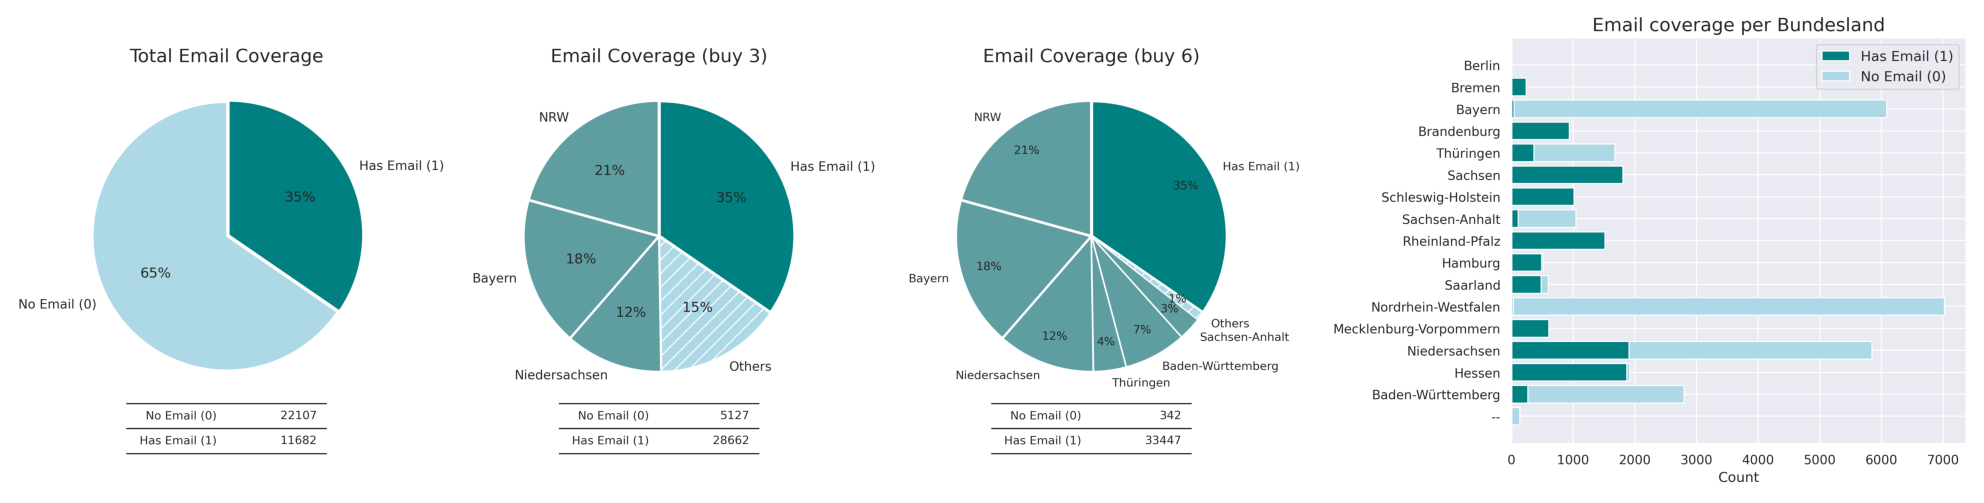

In [88]:
import matplotlib.image as mpimg

# Load the saved image
img = mpimg.imread("plots/email_coverage_comparison_with_tables.png")
tbl = mpimg.imread("plots/school_email_coverage.png")

# Create a side-by-side layout
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [2, 1]})  # 1 row, 2 columns

# Plot the first image (comparison plot)
axes[0].imshow(img)
axes[0].axis('off')  # Turn off axes
# axes[0].set_title("Email Coverage Comparison", fontsize=16)

# Plot the second image (table)
axes[1].imshow(tbl, aspect=1)
axes[1].axis('off')  # Turn off axes
# axes[1].set_title("School Email Coverage Table", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.savefig('plots/plot_conclusion.png', bbox_inches='tight')
plt.show()


**With that we can finally answer our initial questions:**
* **For how many schools (per county) can we get email addresses?**  
    &rarr; Our data set provides 11682 email addresses out of 33789 total, corresponding to a coverage of ~35%. The table 'Email coverage per Bundesland' shows that emails for Bayern and Nordrhein-Westfalen are almost completely missing.
    
* **Should we buy 3rd party data to increase our coverage?**  
    &rarr; Yes, we should buy 3rd party data. While it's not too important to get close to coverage 100% for a survey, it's more important to cover all Bundesländer at least to a certain extent. Therefore, we should at least buy 3rd party data for Nordrhein Westfalen and Bayern.  
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &rarr; Including the three largest missing Bundesländer (NRW, Bayern, Niedersachsen) we could increase our coverage to 85%. Adding Thüringen, Baden-Würrtemberg and Sachsen-Anhalt would increase our coverage to 99%.

(Bonus: Take a look at the section 'Extra: Visualize coverage on map plot of Germany' to see the coverage visualized on a map of Germany!)